In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load CSV file
df = pd.read_csv("traffic_data.csv")

# Convert neighboring intersections into a structured format (list of intersections)
df["Neighboring Intersections"] = df["Neighboring Intersections"].apply(lambda x: x.split(", ") if isinstance(x, str) else [])

# Convert neighboring vehicle counts into numerical lists
df["Neighboring Vehicle Counts"] = df["Neighboring Vehicle Counts"].apply(lambda x: list(map(int, x.split(", "))) if isinstance(x, str) else [])

# Compute aggregated features
df["Total Neighboring Vehicles"] = df["Neighboring Vehicle Counts"].apply(sum)
df["Avg Neighboring Vehicles"] = df["Neighboring Vehicle Counts"].apply(lambda x: sum(x) / len(x) if x else 0)

# Select numeric columns to normalize
num_features = ["Vehicle Count", "Avg Speed", "Total Neighboring Vehicles", "Avg Neighboring Vehicles", "Waiting Time", "Queue Length"]

# Normalize data using MinMaxScaler (0 to 1)
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Label encoding for categorical features
label_encoder = LabelEncoder()
df["Intersection"] = label_encoder.fit_transform(df["Intersection"])
df["Time of Day"] = label_encoder.fit_transform(df["Time of Day"])
df["Signal State"] = label_encoder.fit_transform(df["Signal State"])

import torch

# Select the final set of features for GAN input
features = ["Intersection", "Time of Day", "Vehicle Count", "Avg Speed", 
            "Signal State", "Total Neighboring Vehicles", "Avg Neighboring Vehicles", 
            "Waiting Time", "Queue Length"]

# Convert DataFrame to a NumPy array
data_array = df[features].values.astype(np.float32)

# Convert to PyTorch tensor for GAN
data_tensor = torch.tensor(data_array)

print("Shape of input tensor:", data_tensor.shape)

import torch.nn as nn

# Define Generator
output_dim = data_tensor.shape[1]  # Ensure output matches real data dimensions

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),  # Ensure this matches data_tensor shape
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Probability of being real
        )

    def forward(self, x):
        return self.model(x)

# Set dimensions
input_dim = 10  # Size of the input noise vector
output_dim = data_tensor.shape[1]  # Output dimensions (same as input data features)

# Initialize GAN models
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

# Print model summaries
print(generator)
print(discriminator)


import torch.optim as optim

# Set hyperparameters
batch_size = 32
epochs = 10000
lr = 0.0002

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
loss_fn = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    # Generate random noise for generator
    z = torch.randn(batch_size, input_dim)

    # Generate synthetic traffic data
    fake_data = generator(z)

    # Get real data samples
    real_data = data_tensor[torch.randint(0, data_tensor.shape[0], (batch_size,))]

    # Train Discriminator
    optimizer_D.zero_grad()
    real_loss = loss_fn(discriminator(real_data), torch.ones(batch_size, 1))
    fake_loss = loss_fn(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    optimizer_G.zero_grad()
    g_loss = loss_fn(discriminator(fake_data), torch.ones(batch_size, 1))
    g_loss.backward()
    optimizer_G.step()

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
# Generate synthetic samples
z = torch.randn(10, input_dim)  # Generate 10 synthetic samples
synthetic_data = generator(z).detach().numpy()

# Convert back to original scale
synthetic_data = scaler.inverse_transform(synthetic_data)

# Create a DataFrame
df_synthetic = pd.DataFrame(synthetic_data, columns=features)
print(df_synthetic)


Shape of input tensor: torch.Size([99824, 9])
Generator(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=9, bias=True)
    (5): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Epoch 0, D Loss: 1.3309752941131592, G Loss: 0.6832603812217712
Epoch 1000, D Loss: 0.27752089500427246, G Loss: 2.3648440837860107
Epoch 2000, D Loss: 0.362495481967926, G Loss: 2.5021605491638184
Epoch 3000, D Loss: 0.3789505660533905, G Loss: 3.3489651679992676
Epoch 4000, D Loss: 0.29450109601020813, G Loss: 3.182065963745117
Epoch 5000, D Loss: 0.06088872626423836, G Loss: 3.0685434341430664
Epoch 

ValueError: operands could not be broadcast together with shapes (10,9) (6,) (10,9) 

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# ========================
# 1️⃣ Load and Preprocess Data
# ========================
df = pd.read_csv("traffic_data.csv")  # Update with your filename

# Encode categorical columns (e.g., Intersection, Time of Day)
label_encoders = {}
for col in ["Intersection", "Time of Day"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Process Neighboring Intersections as list of indices
unique_intersections = df["Intersection"].unique()
intersection_map = {val: idx for idx, val in enumerate(unique_intersections)}

df["Neighboring Intersections"] = df["Neighboring Intersections"].apply(
    lambda x: [intersection_map[neigh] for neigh in x.split(", ")] if isinstance(x, str) else []
)

# Convert Neighboring Vehicle Counts to list of integers
df["Neighboring Vehicle Counts"] = df["Neighboring Vehicle Counts"].apply(
    lambda x: list(map(int, x.split(", "))) if isinstance(x, str) else []
)

# Normalize numerical columns
scaler = MinMaxScaler()
numeric_cols = ["Timestamp", "Vehicle Count", "Avg Speed", "Signal State", "Waiting Time", "Queue Length"]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Convert list-based columns to fixed-length vectors
max_neighbors = max(df["Neighboring Intersections"].apply(len))
df["Neighboring Intersections"] = df["Neighboring Intersections"].apply(lambda x: x + [0] * (max_neighbors - len(x)))
df["Neighboring Vehicle Counts"] = df["Neighboring Vehicle Counts"].apply(lambda x: x + [0] * (max_neighbors - len(x)))

# Flatten Neighboring Intersections & Vehicle Counts
df["Neighboring Intersections"] = df["Neighboring Intersections"].apply(lambda x: np.array(x))
df["Neighboring Vehicle Counts"] = df["Neighboring Vehicle Counts"].apply(lambda x: np.array(x))

# Convert to tensor
real_data = torch.tensor(np.hstack(df[numeric_cols + ["Neighboring Intersections", "Neighboring Vehicle Counts"]].values), dtype=torch.float32)

# ========================
# 2️⃣ Define GAN Model
# ========================
latent_dim = 10  # Dimension of random noise
data_dim = real_data.shape[1]  # Must match feature count

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate models
generator = Generator(latent_dim, data_dim)
discriminator = Discriminator(data_dim)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function
loss_fn = nn.BCELoss()

# ========================
# 3️⃣ Train GAN
# ========================
num_epochs = 500
batch_size = 32

for epoch in range(num_epochs):
    # Train Discriminator
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    real_samples = real_data[torch.randint(0, real_data.shape[0], (batch_size,))]

    z = torch.randn(batch_size, latent_dim)
    fake_samples = generator(z).detach()

    d_loss_real = loss_fn(discriminator(real_samples), real_labels)
    d_loss_fake = loss_fn(discriminator(fake_samples), fake_labels)
    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train Generator
    z = torch.randn(batch_size, latent_dim)
    generated_samples = generator(z)
    g_loss = loss_fn(discriminator(generated_samples), real_labels)  # Fool the discriminator

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D Loss = {d_loss.item()}, G Loss = {g_loss.item()}")

# ========================
# 4️⃣ Generate & Post-process Synthetic Data
# ========================
z = torch.randn(10, latent_dim)  # Generate 10 synthetic samples
synthetic_data = generator(z).detach().numpy()

# Reverse scaling
synthetic_data[:, :len(numeric_cols)] = scaler.inverse_transform(synthetic_data[:, :len(numeric_cols)])

# Convert encoded categorical columns back to original labels
for col, le in label_encoders.items():
    col_idx = df.columns.get_loc(col)
    synthetic_data[:, col_idx] = le.inverse_transform(synthetic_data[:, col_idx].astype(int))

# Convert Neighboring Intersections & Vehicle Counts back to lists
neighboring_intersection_cols = list(range(len(numeric_cols), len(numeric_cols) + max_neighbors))
neighboring_vehicle_cols = list(range(len(numeric_cols) + max_neighbors, data_dim))

synthetic_df = pd.DataFrame(synthetic_data, columns=numeric_cols + ["Neighboring Intersections", "Neighboring Vehicle Counts"])
synthetic_df["Neighboring Intersections"] = synthetic_df[neighboring_intersection_cols].apply(lambda x: [int(i) for i in x], axis=1)
synthetic_df["Neighboring Vehicle Counts"] = synthetic_df[neighboring_vehicle_cols].apply(lambda x: [int(i) for i in x], axis=1)

print(synthetic_df.head())

# Save to CSV
synthetic_df.to_csv("synthetic_traffic_data.csv", index=False)


KeyError: 'nt2'

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Load processed data
df = pd.read_csv("traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Timestamp', 'Time of Day', 'Signal State', 'Neighboring Vehicle Count'] + \
           [col for col in df.columns if 'Neighbor_Count' in col]
target = ['Vehicle Count']

# Scaling features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

df[features] = scaler_features.fit_transform(df[features])
df[target] = scaler_target.fit_transform(df[target])

# Convert to tensors
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df[target].values, dtype=torch.float32)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def _init_(self, input_dim, output_dim):
        super(Generator, self)._init_()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def _init_(self, input_dim):
        super(Discriminator, self)._init_()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models
input_dim = X.shape[1]
output_dim = y.shape[1]
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    for real_X, real_y in dataloader:
        batch_size = real_X.size(0)
        
        # Generate fake data
        fake_y = generator(real_X)
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "/mnt/data/generator.pth")
torch.save(discriminator.state_dict(), "/mnt/data/discriminator.pth")

print("GAN training complete. Models saved.")

ValueError: could not convert string to float: 'Morning'

In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df_original = pd.read_csv("traffic_data.csv")  # Replace with actual file path

# Convert 'Time_of_Day' to binary format: Morning (0), Evening (1)
df_original['Time of Day'] = df_original['Time of Day'].map({'Morning': 0, 'Evening': 1})

# Function to adjust timestamps
def convert_seconds_to_time_adjusted(seconds, period):
    base_time = 21600 if period == "Morning" else 64800  # Morning starts at 06:00, Evening starts at 18:00
    total_seconds = base_time + seconds
    return pd.to_datetime(total_seconds, unit='s').time()

# Apply timestamp conversion
df_original['Formatted_Timestamp'] = df_original.apply(
    lambda row: convert_seconds_to_time_adjusted(row['Timestamp'], "Morning" if row['Time of Day'] == 0 else "Evening"), axis=1
)

# Function to remove 'nt' from intersection values
def clean_intersection(value):
    return value.replace('nt', '')

# Clean Intersection column
df_original['Intersection'] = df_original['Intersection'].apply(clean_intersection)

# Process Neighboring Intersections column
df_original['Neighboring Intersections'] = df_original['Neighboring Intersections'].astype(str).apply(
    lambda x: ', '.join([clean_intersection(val) for val in x.split(',')])
)

# Drop columns with NaN values and the original Timestamp column
df_original.dropna(axis=1, inplace=True)
df_original.drop(columns=['Timestamp'], inplace=True, errors='ignore')

# Convert Formatted_Timestamp from datetime.time object to seconds
df_original['Formatted_Timestamp'] = df_original['Formatted_Timestamp'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

# Normalize the Formatted_Timestamp column
scaler_timestamp = MinMaxScaler()
df_original[['Formatted_Timestamp']] = scaler_timestamp.fit_transform(df_original[['Formatted_Timestamp']])

# Process 'Neighbouring Intersection' column: Convert to separate numerical columns
def process_neighbouring_intersections(df, col_name):
    df[col_name] = df[col_name].astype(str).apply(lambda x: x.split(', '))  # Convert string to list
    max_neigh = max(df[col_name].apply(len))  # Find max number of neighbours

    for i in range(max_neigh):
        df[f'Neighbour_{i+1}'] = df[col_name].apply(lambda x: int(x[i]) if i < len(x) else 0)  # Fill missing with 0

    df.drop(columns=[col_name], inplace=True)  # Drop the original column

# Process 'Neighbouring Vehicle Count' column: Convert to separate numerical columns
def process_neighbouring_vehicle_counts(df, col_name):
    df[col_name] = df[col_name].astype(str).apply(lambda x: x.split(', '))  # Convert string to list
    max_counts = max(df[col_name].apply(len))  # Find max number of vehicle counts

    for i in range(max_counts):
        df[f'Neighbour_Count_{i+1}'] = df[col_name].apply(lambda x: int(x[i]) if i < len(x) else 0)  # Fill missing with 0

    df.drop(columns=[col_name], inplace=True)  # Drop the original column

# Apply transformations
process_neighbouring_intersections(df_original, 'Neighboring Intersections')
process_neighbouring_vehicle_counts(df_original, 'Neighboring Vehicle Counts')

# Normalize newly created columns
scaler = MinMaxScaler()
neighbour_cols = [col for col in df_original.columns if 'Neighbour_Count' in col or 'Neighbour_' in col]
df_original[neighbour_cols] = scaler.fit_transform(df_original[neighbour_cols])

# Save the final dataset with all transformations
df_original.to_csv("gan_ready_traffic_data.csv", index=False)

# Display the first few rows
print(df_original.head())

  Intersection  Time of Day  Vehicle Count  Avg Speed  Signal State  \
0            1            0              0       15.5             1   
1            2            0              0       15.5             1   
2            3            0              0       15.5             1   
3            4            0              0       15.5             1   
4            5            0              0       15.5             1   

   Neighboring Vehicle Count  Waiting Time  Queue Length  Formatted_Timestamp  \
0                          0           0.0             0                  0.0   
1                          0           0.0             0                  0.0   
2                          0           0.0             0                  0.0   
3                          0           0.0             0                  0.0   
4                          0           0.0             0                  0.0   

   Neighbour_1  Neighbour_2  Neighbour_3  Neighbour_4  Neighbour_Count_1  \
0     0.07

Epoch [0/20], D Loss: 1.3957817554473877, G Loss: 0.6817786693572998
GAN training complete. Models saved.


C:\Users\hrusi\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\hrusi\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\hrusi\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\hrusi\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\hrusi\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\hrusi\

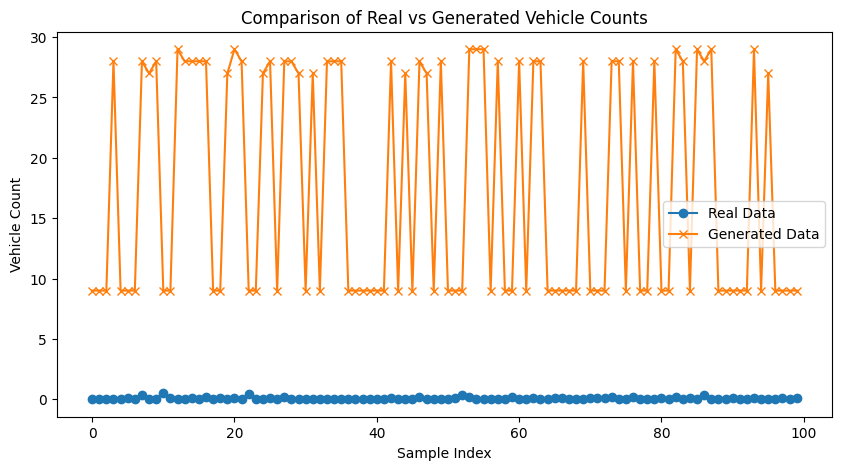

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load processed data
df = pd.read_csv("gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Formatted_Timestamp', 'Time of Day', 'Signal State', 'Neighboring Vehicle Count'] + \
           [col for col in df.columns if 'Neighbour_' in col or 'Neighbour_Count' in col]
target = ['Vehicle Count'] + [col for col in df.columns if 'Neighbour_Count' in col]

# Scaling features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

df[features] = scaler_features.fit_transform(df[features])
df[target] = scaler_target.fit_transform(df[target])

# Convert to tensors
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df[target].values, dtype=torch.float32)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models
input_dim = X.shape[1]
output_dim = y.shape[1]
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for real_X, real_y in dataloader:
        batch_size = real_X.size(0)
        
        # Generate fake data
        noise = torch.randn(batch_size, input_dim)
        fake_y = generator(noise)
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

print("GAN training complete. Models saved.")

# Function to generate vehicle counts and their sources at a given intersection
def generate_traffic(intersection_id, time_of_day, timestamp):
    input_data = np.array([[timestamp, time_of_day] + [0] * (input_dim - 2)])
    input_tensor = torch.tensor(scaler_features.transform(input_data), dtype=torch.float32)
    generated_data = generator(input_tensor).detach().numpy()
    generated_data = scaler_target.inverse_transform(generated_data)
    
    vehicle_count = int(generated_data[0, 0])
    neighbour_counts = generated_data[0, 1:]
    
    return vehicle_count, neighbour_counts

# Generate and compare real vs generated data
real_data_sample = df.sample(100)
generated_data_sample = []

for _, row in real_data_sample.iterrows():
    vehicle_count, _ = generate_traffic(row['Intersection'], row['Time of Day'], row['Formatted_Timestamp'])
    generated_data_sample.append(vehicle_count)

real_vehicle_counts = real_data_sample['Vehicle Count'].values

plt.figure(figsize=(10, 5))
plt.plot(real_vehicle_counts, label="Real Data", marker='o')
plt.plot(generated_data_sample, label="Generated Data", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Vehicle Count")
plt.title("Comparison of Real vs Generated Vehicle Counts")
plt.legend()
plt.show()

In [25]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df_original = pd.read_csv("traffic_data.csv")  # Replace with actual file path

# Rename column for consistency
df_original.rename(columns={'Time of Day': 'Time_of_Day'}, inplace=True)

# Convert 'Time_of_Day' to binary format: Morning (0), Evening (1)
df_original['Time_of_Day'] = df_original['Time_of_Day'].map({'Morning': 0, 'Evening': 1})

# Function to adjust timestamps
def convert_seconds_to_time_adjusted(seconds, period):
    base_time = 21600 if period == "Morning" else 64800  # Morning starts at 06:00, Evening starts at 18:00
    total_seconds = base_time + seconds
    return pd.to_datetime(total_seconds, unit='s').time()

# Apply timestamp conversion
df_original['Formatted_Timestamp'] = df_original.apply(
    lambda row: convert_seconds_to_time_adjusted(row['Timestamp'], "Morning" if row['Time_of_Day'] == 0 else "Evening"), axis=1
)

# Function to remove 'nt' from intersection values
def clean_intersection(value):
    return value.replace('nt', '')

# Clean Intersection column
df_original['Intersection'] = df_original['Intersection'].apply(clean_intersection)

# Process Neighboring Intersections column
df_original['Neighboring Intersections'] = df_original['Neighboring Intersections'].astype(str).apply(
    lambda x: ', '.join([clean_intersection(val) for val in x.split(',')])
)

# Drop columns with NaN values and the original Timestamp column
df_original.dropna(axis=1, inplace=True)
df_original.drop(columns=['Timestamp'], inplace=True, errors='ignore')

# Convert Formatted_Timestamp from datetime.time object to seconds
df_original['Formatted_Timestamp'] = df_original['Formatted_Timestamp'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

# Normalize the Formatted_Timestamp column
scaler_timestamp = MinMaxScaler()
df_original[['Formatted_Timestamp']] = scaler_timestamp.fit_transform(df_original[['Formatted_Timestamp']])

# Convert 'Neighbouring Intersection' and 'Neighbouring Vehicle Count' columns into lists
df_original['Neighboring Intersections'] = df_original['Neighboring Intersections'].apply(lambda x: [int(i.strip()) for i in x.split(',') if i.strip().isdigit()])
df_original['Neighboring Vehicle Counts'] = df_original['Neighboring Vehicle Counts'].apply(lambda x: [int(i.strip()) for i in x.split(',') if i.strip().isdigit()])

# Save the final dataset with optimized columns for GAN training
df_original.to_csv("final_gan_ready_traffic_data.csv", index=False)

# Display the first few rows
print(df_original.head())

  Intersection  Time_of_Day  Vehicle Count  Avg Speed  Signal State  \
0            1            0              0       15.5             1   
1            2            0              0       15.5             1   
2            3            0              0       15.5             1   
3            4            0              0       15.5             1   
4            5            0              0       15.5             1   

   Neighboring Vehicle Count Neighboring Intersections  \
0                          0                    [2, 5]   
1                          0                 [1, 3, 6]   
2                          0                 [2, 4, 7]   
3                          0                    [3, 8]   
4                          0                 [6, 1, 9]   

  Neighboring Vehicle Counts  Waiting Time  Queue Length  Formatted_Timestamp  
0                     [0, 0]           0.0             0                  0.0  
1                  [0, 0, 0]           0.0             0        

In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load processed data
df = pd.read_csv("final_gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Intersection', 'Formatted_Timestamp', 'Time_of_Day', 'Signal State', 'Neighboring Vehicle Count', 'Waiting Time', 'Queue Length']
target_intersections = 'Neighboring Intersections'
target_vehicle_counts = 'Neighboring Vehicle Counts'

# Scaling features
df[features] = MinMaxScaler().fit_transform(df[features])

def process_list_column(column):
    return np.array([np.array(eval(row)) for row in column])

df[target_intersections] = process_list_column(df[target_intersections])
df[target_vehicle_counts] = process_list_column(df[target_vehicle_counts])

# Convert to tensors
X = torch.tensor(df[features].values, dtype=torch.float32)
y_intersections = torch.tensor(np.vstack(df[target_intersections].values), dtype=torch.float32)
y_vehicle_counts = torch.tensor(np.vstack(df[target_vehicle_counts].values), dtype=torch.float32)

dataset = TensorDataset(X, y_intersections, y_vehicle_counts)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def _init_(self, input_dim, output_dim_intersections, output_dim_counts):
        super(Generator, self)._init_()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.out_intersections = nn.Linear(128, output_dim_intersections)
        self.out_counts = nn.Linear(128, output_dim_counts)
    
    def forward(self, x):
        hidden = self.model(x)
        return self.out_intersections(hidden), self.out_counts(hidden)

# Define Discriminator
class Discriminator(nn.Module):
    def _init_(self, input_dim):
        super(Discriminator, self)._init_()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models
input_dim = X.shape[1]
output_dim_intersections = y_intersections.shape[1]
output_dim_counts = y_vehicle_counts.shape[1]
generator = Generator(input_dim, output_dim_intersections, output_dim_counts)
discriminator = Discriminator(output_dim_intersections + output_dim_counts)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 1000
real_values = []
fake_values = []

for epoch in range(num_epochs):
    for real_X, real_y_intersections, real_y_counts in dataloader:
        batch_size = real_X.size(0)
        
        # Generate fake data
        noise = torch.randn(batch_size, input_dim)
        fake_y_intersections, fake_y_counts = generator(noise)
        fake_y = torch.cat((fake_y_intersections, fake_y_counts), dim=1)
        real_y = torch.cat((real_y_intersections, real_y_counts), dim=1)
        
        # Store real and fake values for plotting
        real_values.append(real_y.mean().item())
        fake_values.append(fake_y.mean().item())
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

# Plot real vs fake values
plt.figure(figsize=(10,5))
plt.plot(real_values, label="Real Values")
plt.plot(fake_values, label="Fake Values")
plt.xlabel("Epochs")
plt.ylabel("Mean Vehicle Count")
plt.legend()
plt.title("Comparison of Real and Fake Vehicle Counts")
plt.show()

print("GAN training complete. Models saved.")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (99824,) + inhomogeneous part.

Epoch [0/1000], D Loss: 0.3376374840736389, G Loss: 2.65883207321167
Epoch [1/1000], D Loss: 0.33604878187179565, G Loss: 2.4907805919647217
Epoch [2/1000], D Loss: 0.362824022769928, G Loss: 2.0867745876312256
Epoch [3/1000], D Loss: 0.7329157590866089, G Loss: 1.8248504400253296
Epoch [4/1000], D Loss: 0.8450924158096313, G Loss: 1.3069602251052856
Epoch [5/1000], D Loss: 0.7302849292755127, G Loss: 1.4141244888305664
Epoch [6/1000], D Loss: 0.70951247215271, G Loss: 1.6512974500656128
Epoch [7/1000], D Loss: 0.9406834840774536, G Loss: 1.1547832489013672
Epoch [8/1000], D Loss: 0.8663212060928345, G Loss: 1.2997568845748901
Epoch [9/1000], D Loss: 0.8919845819473267, G Loss: 1.2518140077590942
Epoch [10/1000], D Loss: 0.9582637548446655, G Loss: 1.0749226808547974
Epoch [11/1000], D Loss: 0.9500781297683716, G Loss: 1.1889680624008179
Epoch [12/1000], D Loss: 0.9932230710983276, G Loss: 1.5447739362716675
Epoch [13/1000], D Loss: 0.9768328666687012, G Loss: 1.497902512550354
Epoch [

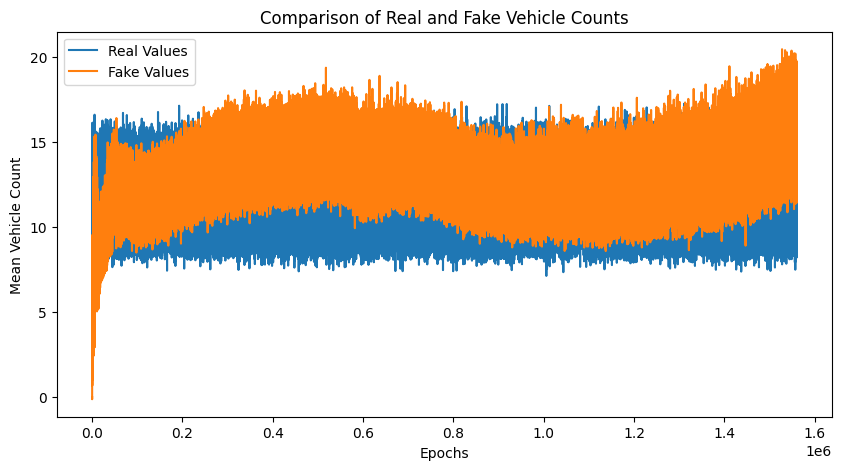

GAN training complete. Models saved.


In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import ast

# Load processed data
df = pd.read_csv("final_gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Intersection', 'Formatted_Timestamp', 'Time_of_Day', 'Signal State', 'Neighboring Vehicle Count', 'Waiting Time', 'Queue Length']
target_intersections = 'Neighboring Intersections'
target_vehicle_counts = 'Neighboring Vehicle Counts'

# Scaling features
df[features] = MinMaxScaler().fit_transform(df[features])

# Function to safely parse list columns
def process_list_column(column):
    return np.array([np.array(ast.literal_eval(row)) if isinstance(row, str) else np.array([]) for row in column], dtype=object)

# Process target columns
df[target_intersections] = process_list_column(df[target_intersections])
df[target_vehicle_counts] = process_list_column(df[target_vehicle_counts])

# Pad sequences to the same length
max_len = max(df[target_intersections].apply(len))
df[target_intersections] = df[target_intersections].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))
df[target_vehicle_counts] = df[target_vehicle_counts].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))

# Convert to tensors
X = torch.tensor(df[features].values, dtype=torch.float32)
y_intersections = torch.tensor(np.vstack(df[target_intersections].values), dtype=torch.float32)
y_vehicle_counts = torch.tensor(np.vstack(df[target_vehicle_counts].values), dtype=torch.float32)

dataset = TensorDataset(X, y_intersections, y_vehicle_counts)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim_intersections, output_dim_counts):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.out_intersections = nn.Linear(128, output_dim_intersections)
        self.out_counts = nn.Linear(128, output_dim_counts)
    
    def forward(self, x):
        hidden = self.model(x)
        return self.out_intersections(hidden), self.out_counts(hidden)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models
input_dim = X.shape[1]
output_dim_intersections = y_intersections.shape[1]
output_dim_counts = y_vehicle_counts.shape[1]
generator = Generator(input_dim, output_dim_intersections, output_dim_counts)
discriminator = Discriminator(output_dim_intersections + output_dim_counts)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 1000
real_values = []
fake_values = []

for epoch in range(num_epochs):
    for real_X, real_y_intersections, real_y_counts in dataloader:
        batch_size = real_X.size(0)
        
        # Generate fake data
        noise = torch.randn(batch_size, input_dim)
        fake_y_intersections, fake_y_counts = generator(noise)
        fake_y = torch.cat((fake_y_intersections, fake_y_counts), dim=1)
        real_y = torch.cat((real_y_intersections, real_y_counts), dim=1)
        
        # Store real and fake values for plotting
        real_values.append(real_y.mean().item())
        fake_values.append(fake_y.mean().item())
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

# Plot real vs fake values
plt.figure(figsize=(10,5))
plt.plot(real_values, label="Real Values")
plt.plot(fake_values, label="Fake Values")
plt.xlabel("Epochs")
plt.ylabel("Mean Vehicle Count")
plt.legend()
plt.title("Comparison of Real and Fake Vehicle Counts")
plt.show()

print("GAN training complete. Models saved.")

Using device: cuda
Epoch [0/1000], D Loss: 0.8959531784057617, G Loss: 1.157080888748169
Epoch [1/1000], D Loss: 0.9911009073257446, G Loss: 1.1386548280715942
Epoch [2/1000], D Loss: 1.1085131168365479, G Loss: 1.0797779560089111
Epoch [3/1000], D Loss: 1.268383502960205, G Loss: 0.8370317220687866
Epoch [4/1000], D Loss: 1.2599737644195557, G Loss: 1.0484899282455444
Epoch [5/1000], D Loss: 1.2998863458633423, G Loss: 0.8784143328666687
Epoch [6/1000], D Loss: 1.2222980260849, G Loss: 0.8384143114089966
Epoch [7/1000], D Loss: 1.262737512588501, G Loss: 0.8040530681610107
Epoch [8/1000], D Loss: 1.2428982257843018, G Loss: 0.7365412712097168
Epoch [9/1000], D Loss: 1.2848831415176392, G Loss: 0.7622828483581543
Epoch [10/1000], D Loss: 1.2367979288101196, G Loss: 0.7738287448883057
Epoch [11/1000], D Loss: 1.325465202331543, G Loss: 0.9784036874771118
Epoch [12/1000], D Loss: 1.2170953750610352, G Loss: 0.9482361674308777
Epoch [13/1000], D Loss: 1.2601587772369385, G Loss: 0.7999784

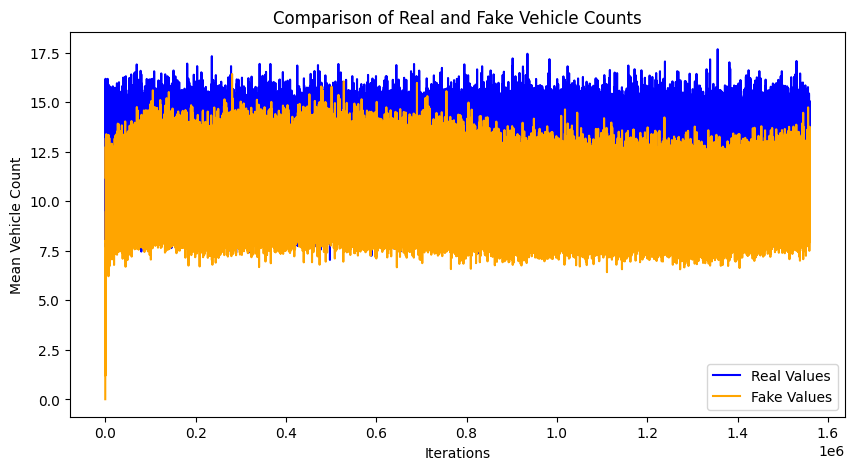

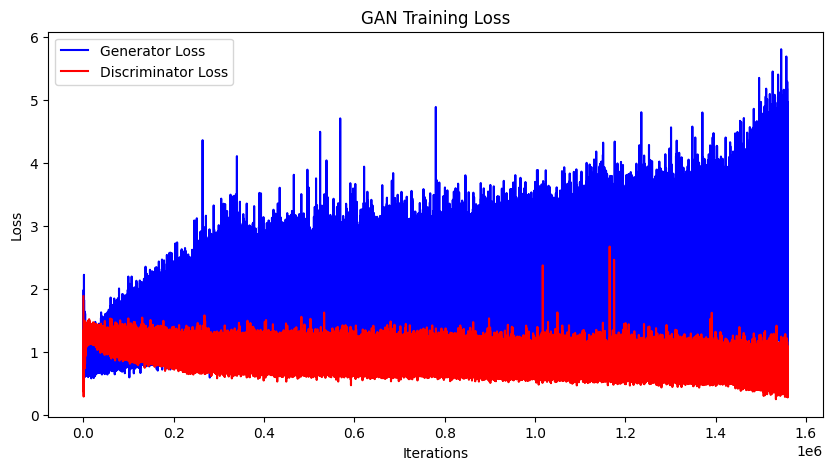

GAN training complete. Models saved.


In [43]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import ast

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load processed data
df = pd.read_csv("final_gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Intersection', 'Formatted_Timestamp', 'Time_of_Day', 'Signal State', 'Neighboring Vehicle Count', 'Waiting Time', 'Queue Length']
target_intersections = 'Neighboring Intersections'
target_vehicle_counts = 'Neighboring Vehicle Counts'

# Scaling features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Function to safely parse list columns
def process_list_column(column):
    return np.array([np.array(ast.literal_eval(row)) if isinstance(row, str) else np.array([]) for row in column], dtype=object)

# Process target columns
df[target_intersections] = process_list_column(df[target_intersections])
df[target_vehicle_counts] = process_list_column(df[target_vehicle_counts])

# Pad sequences to the same length
max_len = max(df[target_intersections].apply(len))
df[target_intersections] = df[target_intersections].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))
df[target_vehicle_counts] = df[target_vehicle_counts].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))

# Convert to tensors and move to device
X = torch.tensor(df[features].values, dtype=torch.float32).to(device)
y_intersections = torch.tensor(np.vstack(df[target_intersections].values), dtype=torch.float32).to(device)
y_vehicle_counts = torch.tensor(np.vstack(df[target_vehicle_counts].values), dtype=torch.float32).to(device)

dataset = TensorDataset(X, y_intersections, y_vehicle_counts)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim_intersections, output_dim_counts):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        self.out_intersections = nn.Linear(256, output_dim_intersections)
        self.out_counts = nn.Linear(256, output_dim_counts)
    
    def forward(self, x):
        hidden = self.model(x)
        return self.out_intersections(hidden), self.out_counts(hidden)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models and move them to device
input_dim = X.shape[1]
output_dim_intersections = y_intersections.shape[1]
output_dim_counts = y_vehicle_counts.shape[1]
generator = Generator(input_dim, output_dim_intersections, output_dim_counts).to(device)
discriminator = Discriminator(output_dim_intersections + output_dim_counts).to(device)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training loop
num_epochs = 1000
real_values = []
fake_values = []
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for real_X, real_y_intersections, real_y_counts in dataloader:
        batch_size = real_X.size(0)
        
        # Move data to device
        real_X, real_y_intersections, real_y_counts = real_X.to(device), real_y_intersections.to(device), real_y_counts.to(device)

        # Generate fake data
        noise = torch.randn(batch_size, input_dim, device=device)
        fake_y_intersections, fake_y_counts = generator(noise)
        fake_y = torch.cat((fake_y_intersections, fake_y_counts), dim=1)
        real_y = torch.cat((real_y_intersections, real_y_counts), dim=1)
        
        # Store real and fake values for plotting
        real_values.append(real_y.mean().item())
        fake_values.append(fake_y.mean().item())
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Store losses for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

   
    print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "generator_gpu.pth")
torch.save(discriminator.state_dict(), "discriminator_gpu.pth")

# Plot real vs fake values
plt.figure(figsize=(10,5))
plt.plot(real_values, label="Real Values", color="blue")
plt.plot(fake_values, label="Fake Values", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Mean Vehicle Count")
plt.legend()
plt.title("Comparison of Real and Fake Vehicle Counts")
plt.show()

# Plot generator and discriminator losses
plt.figure(figsize=(10,5))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Loss")
plt.show()

print("GAN training complete. Models saved.")

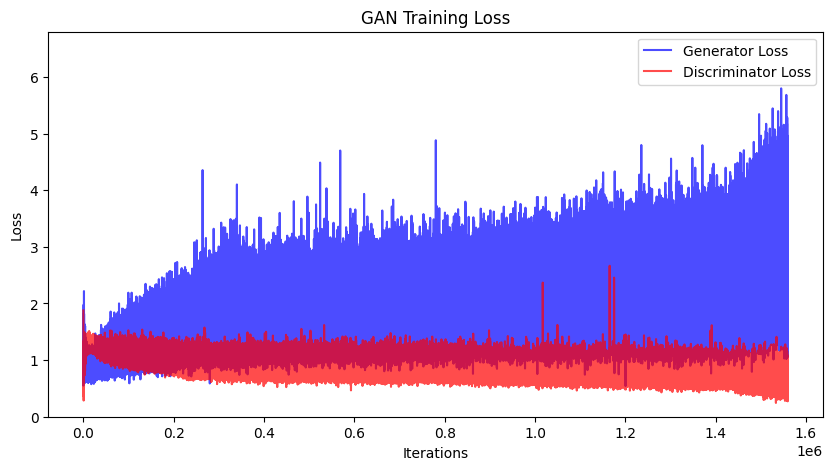

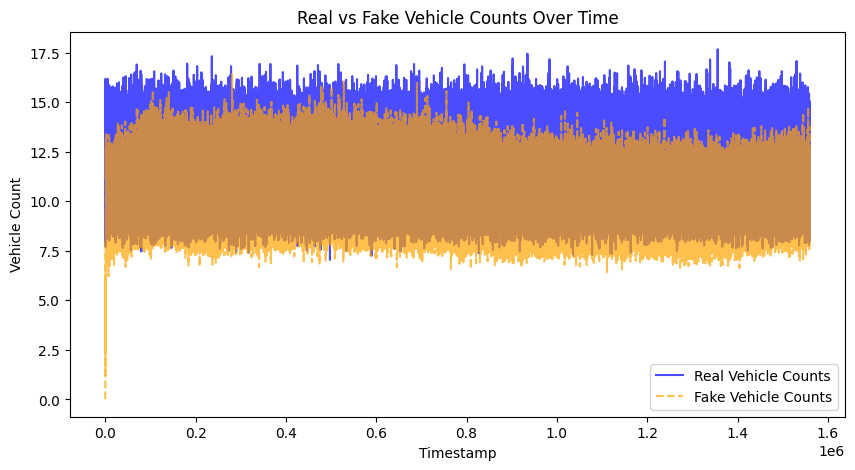

In [44]:
import matplotlib.pyplot as plt

import numpy as np



# Ensure losses are correctly plotted without outliers

max_g_loss = max(g_losses) if g_losses else 3  # Ensure reasonable max limit

max_d_loss = max(d_losses) if d_losses else 3



# Plot Generator and Discriminator Losses

plt.figure(figsize=(10,5))

plt.plot(g_losses, label="Generator Loss", color="blue", alpha=0.7)

plt.plot(d_losses, label="Discriminator Loss", color="red", alpha=0.7)

plt.xlabel("Iterations")

plt.ylabel("Loss")

plt.ylim(0, max(max_g_loss, max_d_loss) + 1)  # Ensure correct y-axis scaling

plt.legend()

plt.title("GAN Training Loss")

plt.show()



# ---- Real vs Fake Vehicle Counts Over Timestamps ----



# Generate fake timestamps for demonstration (Replace with actual timestamps)

timestamps = np.arange(len(real_values))  # Assuming one value per iteration



plt.figure(figsize=(10,5))

plt.plot(timestamps, real_values, label="Real Vehicle Counts", color="blue", alpha=0.7)

plt.plot(timestamps, fake_values, label="Fake Vehicle Counts", color="orange", linestyle="dashed", alpha=0.7)

plt.xlabel("Timestamp")

plt.ylabel("Vehicle Count")

plt.legend()

plt.title("Real vs Fake Vehicle Counts Over Time")

plt.show()

Using device: cuda
Epoch [0/100], D Loss: 0.5408437252044678, G Loss: 1.8071095943450928
Epoch [1/100], D Loss: 0.856906533241272, G Loss: 1.346996545791626
Epoch [2/100], D Loss: 1.086409330368042, G Loss: 1.0734994411468506
Epoch [3/100], D Loss: 1.110988736152649, G Loss: 1.011648178100586
Epoch [4/100], D Loss: 1.1655693054199219, G Loss: 1.1657589673995972
Epoch [5/100], D Loss: 1.1369401216506958, G Loss: 0.961675226688385
Epoch [6/100], D Loss: 1.2416365146636963, G Loss: 0.746326208114624
Epoch [7/100], D Loss: 1.2708688974380493, G Loss: 0.8316538333892822
Epoch [8/100], D Loss: 1.2743632793426514, G Loss: 0.7983694672584534
Epoch [9/100], D Loss: 1.3743287324905396, G Loss: 0.7530959248542786
Epoch [10/100], D Loss: 1.3473973274230957, G Loss: 0.795043408870697
Epoch [11/100], D Loss: 1.302412986755371, G Loss: 0.82753986120224
Epoch [12/100], D Loss: 1.3515260219573975, G Loss: 0.779522180557251
Epoch [13/100], D Loss: 1.3638314008712769, G Loss: 0.8959014415740967
Epoch [14

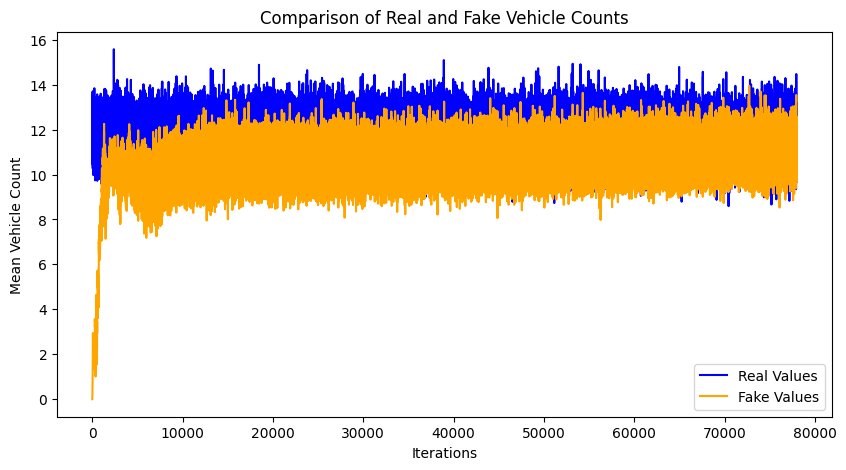

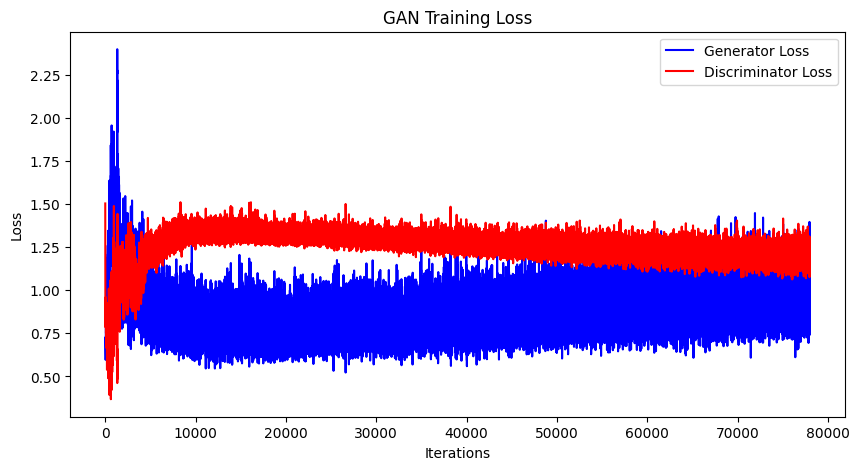

GAN training complete. Models saved.


In [50]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import ast

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load processed data
df = pd.read_csv("final_gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Intersection', 'Formatted_Timestamp', 'Time_of_Day', 'Signal State', 'Neighboring Vehicle Count', 'Waiting Time', 'Queue Length']
target_intersections = 'Neighboring Intersections'
target_vehicle_counts = 'Neighboring Vehicle Counts'

# Scaling features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Function to safely parse list columns
def process_list_column(column):
    return np.array([np.array(ast.literal_eval(row)) if isinstance(row, str) else np.array([]) for row in column], dtype=object)

# Process target columns
df[target_intersections] = process_list_column(df[target_intersections])
df[target_vehicle_counts] = process_list_column(df[target_vehicle_counts])

# Pad sequences to the same length
max_len = max(df[target_intersections].apply(len))
df[target_intersections] = df[target_intersections].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))
df[target_vehicle_counts] = df[target_vehicle_counts].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))

# Convert to tensors and move to device
X = torch.tensor(df[features].values, dtype=torch.float32).to(device)
y_intersections = torch.tensor(np.vstack(df[target_intersections].values), dtype=torch.float32).to(device)
y_vehicle_counts = torch.tensor(np.vstack(df[target_vehicle_counts].values), dtype=torch.float32).to(device)

dataset = TensorDataset(X, y_intersections, y_vehicle_counts)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim_intersections, output_dim_counts):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        self.out_intersections = nn.Linear(256, output_dim_intersections)
        self.out_counts = nn.Linear(256, output_dim_counts)
    
    def forward(self, x):
        hidden = self.model(x)
        return self.out_intersections(hidden), self.out_counts(hidden)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models and move them to device
input_dim = X.shape[1]
output_dim_intersections = y_intersections.shape[1]
output_dim_counts = y_vehicle_counts.shape[1]
generator = Generator(input_dim, output_dim_intersections, output_dim_counts).to(device)
discriminator = Discriminator(output_dim_intersections + output_dim_counts).to(device)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training loop
num_epochs = 100
real_values = []
fake_values = []
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for real_X, real_y_intersections, real_y_counts in dataloader:
        batch_size = real_X.size(0)
        
        # Move data to device
        real_X, real_y_intersections, real_y_counts = real_X.to(device), real_y_intersections.to(device), real_y_counts.to(device)

        # Generate fake data
        noise = torch.randn(batch_size, input_dim, device=device)
        fake_y_intersections, fake_y_counts = generator(noise)
        fake_y = torch.cat((fake_y_intersections, fake_y_counts), dim=1)
        real_y = torch.cat((real_y_intersections, real_y_counts), dim=1)
        
        # # Store real and fake values for plotting
        # real_values.append(real_y.mean().item())
        # fake_values.append(fake_y.mean().item())
        real_values.append(real_y)
        fake_values.append(fake_y)
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Store losses for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

   
    print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "generator_gpu.pth")
torch.save(discriminator.state_dict(), "discriminator_gpu.pth")

# Convert CUDA tensors to CPU, detach, and convert to NumPy
real_values = [val.detach().cpu().numpy().mean() for val in real_values]
fake_values = [val.detach().cpu().numpy().mean() for val in fake_values]


# Plot real vs fake values
plt.figure(figsize=(10,5))
plt.plot(real_values, label="Real Values", color="blue")
plt.plot(fake_values, label="Fake Values", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Mean Vehicle Count")
plt.legend()
plt.title("Comparison of Real and Fake Vehicle Counts")
plt.show()

# Plot generator and discriminator losses
plt.figure(figsize=(10,5))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Loss")
plt.show()

print("GAN training complete. Models saved.")

Using device: cuda
Epoch [0/1000], D Loss: 0.6650399565696716, G Loss: 1.2710798978805542
Epoch [1/1000], D Loss: 0.8616523146629333, G Loss: 1.3276686668395996
Epoch [2/1000], D Loss: 0.880600094795227, G Loss: 1.1895592212677002
Epoch [3/1000], D Loss: 0.9779003858566284, G Loss: 1.44127357006073
Epoch [4/1000], D Loss: 1.126427173614502, G Loss: 0.890574038028717
Epoch [5/1000], D Loss: 1.1243412494659424, G Loss: 0.8001600503921509
Epoch [6/1000], D Loss: 1.2087376117706299, G Loss: 1.0478460788726807
Epoch [7/1000], D Loss: 1.175382137298584, G Loss: 0.814609169960022
Epoch [8/1000], D Loss: 1.1880347728729248, G Loss: 0.9830751419067383
Epoch [9/1000], D Loss: 1.1861217021942139, G Loss: 1.0708286762237549
Epoch [10/1000], D Loss: 1.1986403465270996, G Loss: 0.9859002828598022
Epoch [11/1000], D Loss: 1.2149481773376465, G Loss: 0.8909424543380737
Epoch [12/1000], D Loss: 1.2301486730575562, G Loss: 0.7527459859848022
Epoch [13/1000], D Loss: 1.1962751150131226, G Loss: 0.8157371

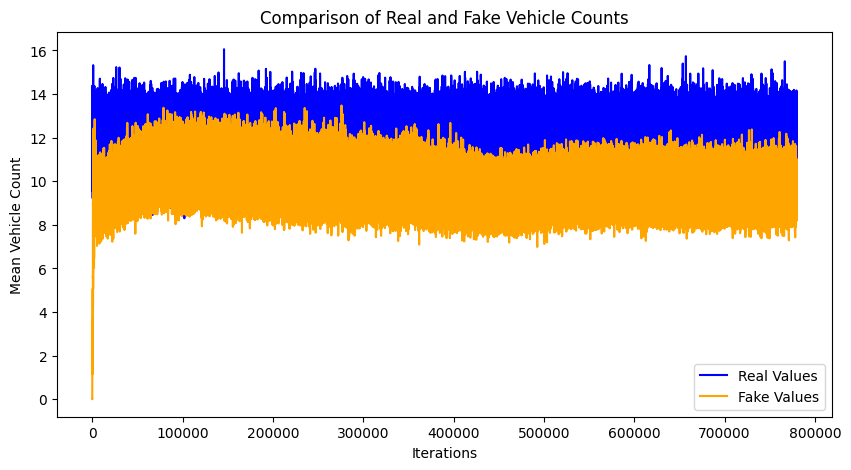

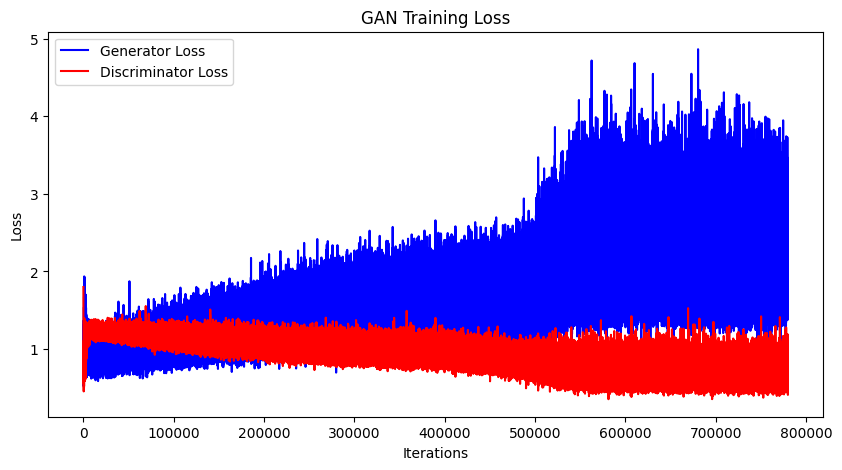

GAN training complete. Models saved.


In [51]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import ast

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load processed data
df = pd.read_csv("final_gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Intersection', 'Formatted_Timestamp', 'Time_of_Day', 'Signal State', 'Neighboring Vehicle Count', 'Waiting Time', 'Queue Length']
target_intersections = 'Neighboring Intersections'
target_vehicle_counts = 'Neighboring Vehicle Counts'

# Scaling features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Function to safely parse list columns
def process_list_column(column):
    return np.array([np.array(ast.literal_eval(row)) if isinstance(row, str) else np.array([]) for row in column], dtype=object)

# Process target columns
df[target_intersections] = process_list_column(df[target_intersections])
df[target_vehicle_counts] = process_list_column(df[target_vehicle_counts])

# Pad sequences to the same length
max_len = max(df[target_intersections].apply(len))
df[target_intersections] = df[target_intersections].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))
df[target_vehicle_counts] = df[target_vehicle_counts].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))

# Convert to tensors and move to device
X = torch.tensor(df[features].values, dtype=torch.float32).to(device)
y_intersections = torch.tensor(np.vstack(df[target_intersections].values), dtype=torch.float32).to(device)
y_vehicle_counts = torch.tensor(np.vstack(df[target_vehicle_counts].values), dtype=torch.float32).to(device)

dataset = TensorDataset(X, y_intersections, y_vehicle_counts)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim_intersections, output_dim_counts):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        self.out_intersections = nn.Linear(256, output_dim_intersections)
        self.out_counts = nn.Linear(256, output_dim_counts)
    
    def forward(self, x):
        hidden = self.model(x)
        return self.out_intersections(hidden), self.out_counts(hidden)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models and move them to device
input_dim = X.shape[1]
output_dim_intersections = y_intersections.shape[1]
output_dim_counts = y_vehicle_counts.shape[1]
generator = Generator(input_dim, output_dim_intersections, output_dim_counts).to(device)
discriminator = Discriminator(output_dim_intersections + output_dim_counts).to(device)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training loop
num_epochs = 1000
real_values = []
fake_values = []
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for real_X, real_y_intersections, real_y_counts in dataloader:
        batch_size = real_X.size(0)
        
        # Move data to device
        real_X, real_y_intersections, real_y_counts = real_X.to(device), real_y_intersections.to(device), real_y_counts.to(device)

        # Generate fake data
        noise = torch.randn(batch_size, input_dim, device=device)
        fake_y_intersections, fake_y_counts = generator(noise)
        fake_y = torch.cat((fake_y_intersections, fake_y_counts), dim=1)
        real_y = torch.cat((real_y_intersections, real_y_counts), dim=1)
        
        # # Store real and fake values for plotting
        # real_values.append(real_y.mean().item())
        # fake_values.append(fake_y.mean().item())
        real_values.append(real_y)
        fake_values.append(fake_y)
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Store losses for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

   
    print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "generator_gpu_final.pth")
torch.save(discriminator.state_dict(), "discriminator_gpu_final.pth")

# Convert CUDA tensors to CPU, detach, and convert to NumPy
real_values = [val.detach().cpu().numpy().mean() for val in real_values]
fake_values = [val.detach().cpu().numpy().mean() for val in fake_values]


# Plot real vs fake values
plt.figure(figsize=(10,5))
plt.plot(real_values, label="Real Values", color="blue")
plt.plot(fake_values, label="Fake Values", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Mean Vehicle Count")
plt.legend()
plt.title("Comparison of Real and Fake Vehicle Counts")
plt.show()

# Plot generator and discriminator losses
plt.figure(figsize=(10,5))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Loss")
plt.show()

print("GAN training complete. Models saved.")

Using device: cuda
Epoch [0/200], D Loss: 0.9235350489616394, G Loss: 0.9189099073410034
Epoch [1/200], D Loss: 0.7117482423782349, G Loss: 1.001929521560669
Epoch [2/200], D Loss: 1.0280036926269531, G Loss: 1.2598927021026611
Epoch [3/200], D Loss: 0.7966334819793701, G Loss: 1.104565978050232
Epoch [4/200], D Loss: 1.0530973672866821, G Loss: 1.0388965606689453
Epoch [5/200], D Loss: 0.9697631001472473, G Loss: 1.103010654449463
Epoch [6/200], D Loss: 1.1501219272613525, G Loss: 1.0414907932281494
Epoch [7/200], D Loss: 1.057325005531311, G Loss: 1.0093870162963867
Epoch [8/200], D Loss: 1.1362316608428955, G Loss: 0.9480286836624146
Epoch [9/200], D Loss: 1.0723521709442139, G Loss: 0.9332656264305115
Epoch [10/200], D Loss: 1.0023913383483887, G Loss: 1.085158348083496
Epoch [11/200], D Loss: 0.7558330297470093, G Loss: 1.2850955724716187
Epoch [12/200], D Loss: 1.0803325176239014, G Loss: 0.9864091277122498
Epoch [13/200], D Loss: 1.1763375997543335, G Loss: 0.9443851113319397
Ep

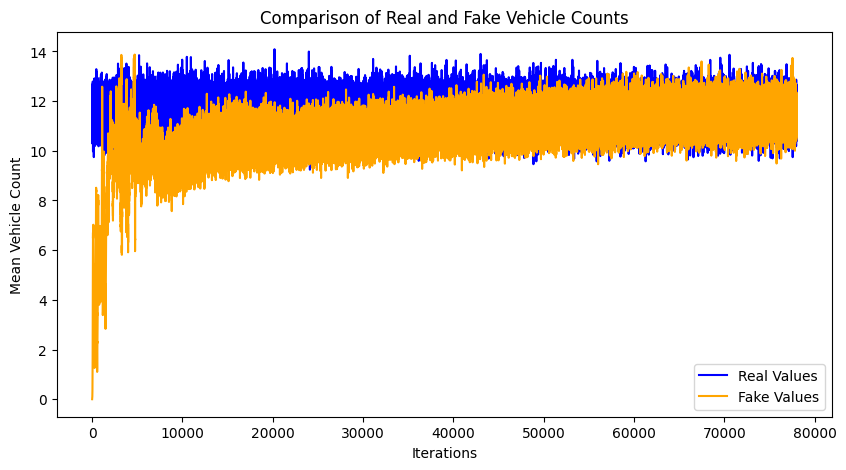

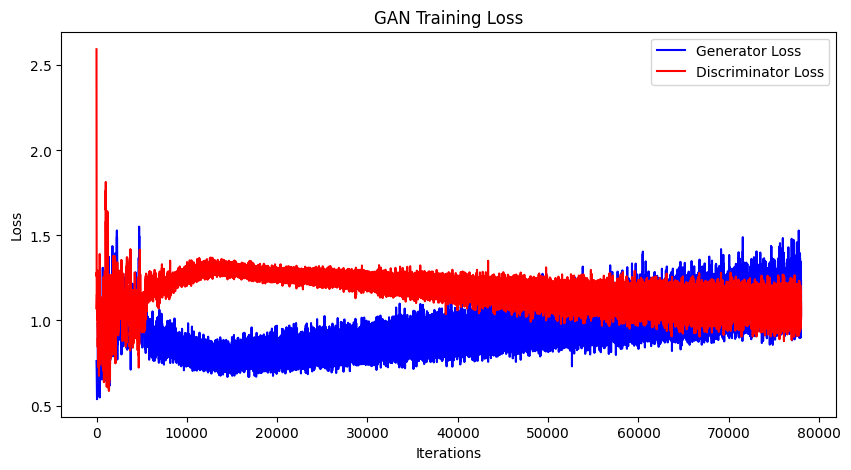

GAN training complete. Models saved.


In [55]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import ast

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load processed data
df = pd.read_csv("final_gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Intersection', 'Formatted_Timestamp', 'Time_of_Day', 'Signal State', 'Neighboring Vehicle Count', 'Waiting Time', 'Queue Length']
target_intersections = 'Neighboring Intersections'
target_vehicle_counts = 'Neighboring Vehicle Counts'

# Scaling features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Function to safely parse list columns
def process_list_column(column):
    return np.array([np.array(ast.literal_eval(row)) if isinstance(row, str) else np.array([]) for row in column], dtype=object)

# Process target columns
df[target_intersections] = process_list_column(df[target_intersections])
df[target_vehicle_counts] = process_list_column(df[target_vehicle_counts])

# Pad sequences to the same length
max_len = max(df[target_intersections].apply(len))
df[target_intersections] = df[target_intersections].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))
df[target_vehicle_counts] = df[target_vehicle_counts].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))

# Convert to tensors and move to device
X = torch.tensor(df[features].values, dtype=torch.float32).to(device)
y_intersections = torch.tensor(np.vstack(df[target_intersections].values), dtype=torch.float32).to(device)
y_vehicle_counts = torch.tensor(np.vstack(df[target_vehicle_counts].values), dtype=torch.float32).to(device)

dataset = TensorDataset(X, y_intersections, y_vehicle_counts)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim_intersections, output_dim_counts):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        self.out_intersections = nn.Linear(256, output_dim_intersections)
        self.out_counts = nn.Linear(256, output_dim_counts)
    
    def forward(self, x):
        hidden = self.model(x)
        return self.out_intersections(hidden), self.out_counts(hidden)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models and move them to device
input_dim = X.shape[1]
output_dim_intersections = y_intersections.shape[1]
output_dim_counts = y_vehicle_counts.shape[1]
generator = Generator(input_dim, output_dim_intersections, output_dim_counts).to(device)
discriminator = Discriminator(output_dim_intersections + output_dim_counts).to(device)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training loop
num_epochs = 200
real_values = []
fake_values = []
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for real_X, real_y_intersections, real_y_counts in dataloader:
        batch_size = real_X.size(0)
        
        # Move data to device
        real_X, real_y_intersections, real_y_counts = real_X.to(device), real_y_intersections.to(device), real_y_counts.to(device)

        # Generate fake data
        noise = torch.randn(batch_size, input_dim, device=device)
        fake_y_intersections, fake_y_counts = generator(noise)
        fake_y = torch.cat((fake_y_intersections, fake_y_counts), dim=1)
        real_y = torch.cat((real_y_intersections, real_y_counts), dim=1)
        
        # # Store real and fake values for plotting
        # real_values.append(real_y.mean().item())
        # fake_values.append(fake_y.mean().item())
        real_values.append(real_y)
        fake_values.append(fake_y)
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Store losses for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

   
    print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "generator_gpu_final.pth")
torch.save(discriminator.state_dict(), "discriminator_gpu_final.pth")

# Convert CUDA tensors to CPU, detach, and convert to NumPy
real_values = [val.detach().cpu().numpy().mean() for val in real_values]
fake_values = [val.detach().cpu().numpy().mean() for val in fake_values]


# Plot real vs fake values
plt.figure(figsize=(10,5))
plt.plot(real_values, label="Real Values", color="blue")
plt.plot(fake_values, label="Fake Values", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Mean Vehicle Count")
plt.legend()
plt.title("Comparison of Real and Fake Vehicle Counts")
plt.show()

# Plot generator and discriminator losses
plt.figure(figsize=(10,5))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Loss")
plt.show()

print("GAN training complete. Models saved.")

Using device: cuda
Epoch [0/250], D Loss: 0.8595536947250366, G Loss: 0.7331454157829285
Epoch [1/250], D Loss: 0.7626857757568359, G Loss: 1.1065022945404053
Epoch [2/250], D Loss: 0.7966283559799194, G Loss: 1.0612250566482544
Epoch [3/250], D Loss: 1.1494896411895752, G Loss: 0.9690066576004028
Epoch [4/250], D Loss: 0.9334564208984375, G Loss: 1.2961541414260864
Epoch [5/250], D Loss: 0.8721288442611694, G Loss: 1.2174845933914185
Epoch [6/250], D Loss: 0.9911046028137207, G Loss: 0.9727361798286438
Epoch [7/250], D Loss: 1.0244139432907104, G Loss: 1.137044072151184
Epoch [8/250], D Loss: 1.1434009075164795, G Loss: 1.0039877891540527
Epoch [9/250], D Loss: 1.261182188987732, G Loss: 0.8760749697685242
Epoch [10/250], D Loss: 1.003125548362732, G Loss: 1.0435130596160889
Epoch [11/250], D Loss: 1.0413427352905273, G Loss: 0.9618039131164551
Epoch [12/250], D Loss: 1.1652026176452637, G Loss: 0.8803067207336426
Epoch [13/250], D Loss: 1.1431405544281006, G Loss: 0.9027425050735474


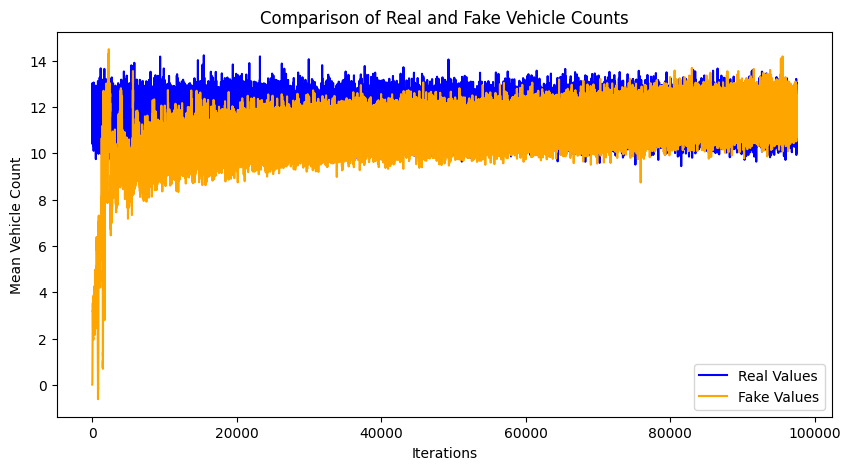

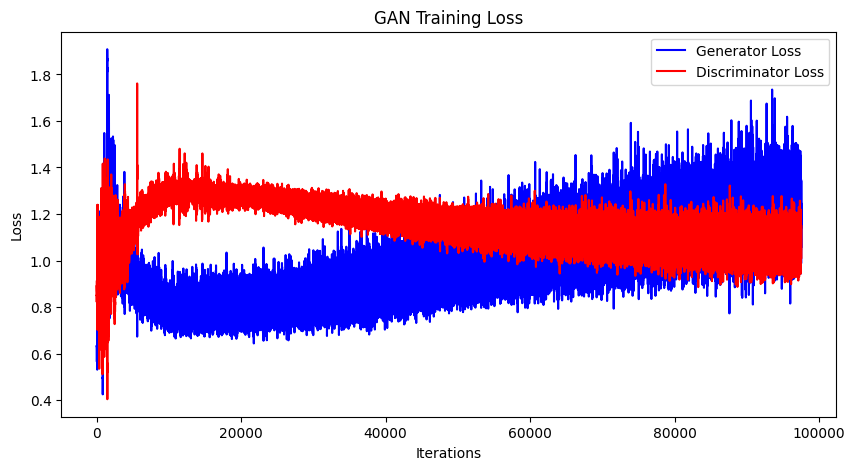

GAN training complete. Models saved.


In [56]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import ast

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load processed data
df = pd.read_csv("final_gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Intersection', 'Formatted_Timestamp', 'Time_of_Day', 'Signal State', 'Neighboring Vehicle Count', 'Waiting Time', 'Queue Length']
target_intersections = 'Neighboring Intersections'
target_vehicle_counts = 'Neighboring Vehicle Counts'

# Scaling features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Function to safely parse list columns
def process_list_column(column):
    return np.array([np.array(ast.literal_eval(row)) if isinstance(row, str) else np.array([]) for row in column], dtype=object)

# Process target columns
df[target_intersections] = process_list_column(df[target_intersections])
df[target_vehicle_counts] = process_list_column(df[target_vehicle_counts])

# Pad sequences to the same length
max_len = max(df[target_intersections].apply(len))
df[target_intersections] = df[target_intersections].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))
df[target_vehicle_counts] = df[target_vehicle_counts].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))

# Convert to tensors and move to device
X = torch.tensor(df[features].values, dtype=torch.float32).to(device)
y_intersections = torch.tensor(np.vstack(df[target_intersections].values), dtype=torch.float32).to(device)
y_vehicle_counts = torch.tensor(np.vstack(df[target_vehicle_counts].values), dtype=torch.float32).to(device)

dataset = TensorDataset(X, y_intersections, y_vehicle_counts)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim_intersections, output_dim_counts):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        self.out_intersections = nn.Linear(256, output_dim_intersections)
        self.out_counts = nn.Linear(256, output_dim_counts)
    
    def forward(self, x):
        hidden = self.model(x)
        return self.out_intersections(hidden), self.out_counts(hidden)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models and move them to device
input_dim = X.shape[1]
output_dim_intersections = y_intersections.shape[1]
output_dim_counts = y_vehicle_counts.shape[1]
generator = Generator(input_dim, output_dim_intersections, output_dim_counts).to(device)
discriminator = Discriminator(output_dim_intersections + output_dim_counts).to(device)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training loop
num_epochs = 250
real_values = []
fake_values = []
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for real_X, real_y_intersections, real_y_counts in dataloader:
        batch_size = real_X.size(0)
        
        # Move data to device
        real_X, real_y_intersections, real_y_counts = real_X.to(device), real_y_intersections.to(device), real_y_counts.to(device)

        # Generate fake data
        noise = torch.randn(batch_size, input_dim, device=device)
        fake_y_intersections, fake_y_counts = generator(noise)
        fake_y = torch.cat((fake_y_intersections, fake_y_counts), dim=1)
        real_y = torch.cat((real_y_intersections, real_y_counts), dim=1)
        
        # # Store real and fake values for plotting
        # real_values.append(real_y.mean().item())
        # fake_values.append(fake_y.mean().item())
        real_values.append(real_y)
        fake_values.append(fake_y)
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Store losses for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

   
    print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "generator_gpu_final.pth")
torch.save(discriminator.state_dict(), "discriminator_gpu_final.pth")

# Convert CUDA tensors to CPU, detach, and convert to NumPy
real_values = [val.detach().cpu().numpy().mean() for val in real_values]
fake_values = [val.detach().cpu().numpy().mean() for val in fake_values]


# Plot real vs fake values
plt.figure(figsize=(10,5))
plt.plot(real_values, label="Real Values", color="blue")
plt.plot(fake_values, label="Fake Values", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Mean Vehicle Count")
plt.legend()
plt.title("Comparison of Real and Fake Vehicle Counts")
plt.show()

# Plot generator and discriminator losses
plt.figure(figsize=(10,5))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Loss")
plt.show()

print("GAN training complete. Models saved.")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert real and fake values to numpy arrays
real_values_np = np.array(real_values)
fake_values_np = np.array(fake_values)

# Compute MAE and RMSE
mae = mean_absolute_error(real_values_np, fake_values_np)
rmse = np.sqrt(mean_squared_error(real_values_np, fake_values_np))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

NameError: name 'real_values' is not defined

Using device: cuda
Epoch [0/250], D Loss: 0.7596402764320374, G Loss: 1.1132338047027588
Epoch [1/250], D Loss: 0.6682865619659424, G Loss: 1.2662911415100098
Epoch [2/250], D Loss: 0.8071065545082092, G Loss: 1.1530383825302124
Epoch [3/250], D Loss: 0.8546363115310669, G Loss: 1.230993628501892
Epoch [4/250], D Loss: 1.2902770042419434, G Loss: 0.9153032302856445
Epoch [5/250], D Loss: 1.0779078006744385, G Loss: 1.169834852218628
Epoch [6/250], D Loss: 0.9891222715377808, G Loss: 1.039832353591919
Epoch [7/250], D Loss: 1.1925725936889648, G Loss: 0.9690827131271362
Epoch [8/250], D Loss: 0.9644476175308228, G Loss: 0.9603378772735596
Epoch [9/250], D Loss: 1.1466163396835327, G Loss: 0.9446567893028259
Epoch [10/250], D Loss: 0.9928725957870483, G Loss: 1.0735187530517578
Epoch [11/250], D Loss: 1.1693615913391113, G Loss: 0.9145617485046387
Epoch [12/250], D Loss: 1.1106021404266357, G Loss: 0.984254777431488
Epoch [13/250], D Loss: 1.1911351680755615, G Loss: 0.9723750948905945
E

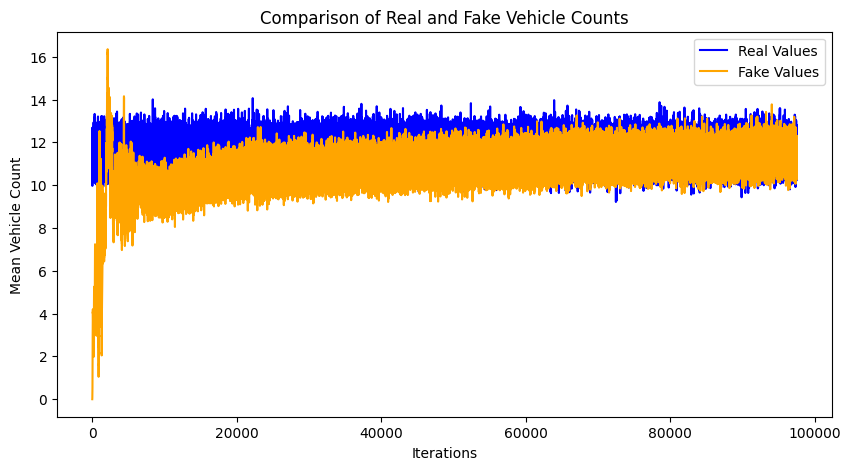

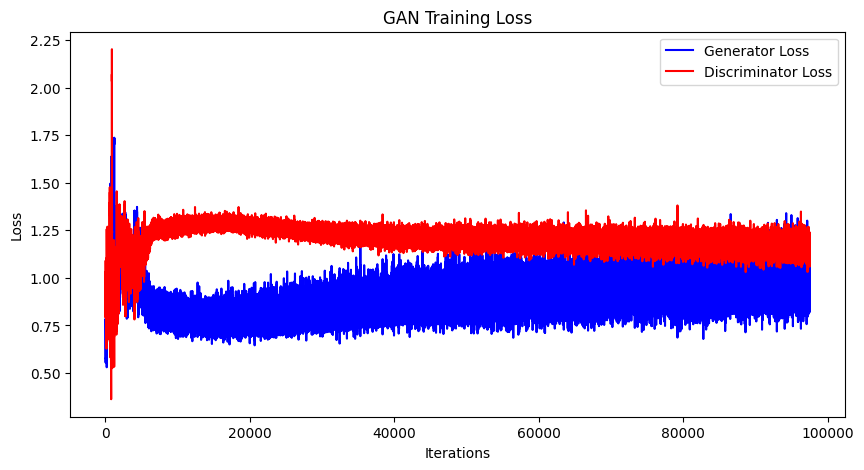

GAN training complete. Models saved.


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import ast

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load processed data
df = pd.read_csv("final_gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Intersection', 'Formatted_Timestamp', 'Time_of_Day', 'Signal State', 'Neighboring Vehicle Count', 'Waiting Time', 'Queue Length']
target_intersections = 'Neighboring Intersections'
target_vehicle_counts = 'Neighboring Vehicle Counts'

# Scaling features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Function to safely parse list columns
def process_list_column(column):
    return np.array([np.array(ast.literal_eval(row)) if isinstance(row, str) else np.array([]) for row in column], dtype=object)

# Process target columns
df[target_intersections] = process_list_column(df[target_intersections])
df[target_vehicle_counts] = process_list_column(df[target_vehicle_counts])

# Pad sequences to the same length
max_len = max(df[target_intersections].apply(len))
df[target_intersections] = df[target_intersections].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))
df[target_vehicle_counts] = df[target_vehicle_counts].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))

# Convert to tensors and move to device
X = torch.tensor(df[features].values, dtype=torch.float32).to(device)
y_intersections = torch.tensor(np.vstack(df[target_intersections].values), dtype=torch.float32).to(device)
y_vehicle_counts = torch.tensor(np.vstack(df[target_vehicle_counts].values), dtype=torch.float32).to(device)

dataset = TensorDataset(X, y_intersections, y_vehicle_counts)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim_intersections, output_dim_counts):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        self.out_intersections = nn.Linear(256, output_dim_intersections)
        self.out_counts = nn.Linear(256, output_dim_counts)
    
    def forward(self, x):
        hidden = self.model(x)
        return self.out_intersections(hidden), self.out_counts(hidden)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models and move them to device
input_dim = X.shape[1]
output_dim_intersections = y_intersections.shape[1]
output_dim_counts = y_vehicle_counts.shape[1]
generator = Generator(input_dim, output_dim_intersections, output_dim_counts).to(device)
discriminator = Discriminator(output_dim_intersections + output_dim_counts).to(device)

# Define loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Training loop
num_epochs = 250
real_values = []
fake_values = []
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for real_X, real_y_intersections, real_y_counts in dataloader:
        batch_size = real_X.size(0)
        
        # Move data to device
        real_X, real_y_intersections, real_y_counts = real_X.to(device), real_y_intersections.to(device), real_y_counts.to(device)

        # Generate fake data
        noise = torch.randn(batch_size, input_dim, device=device)
        fake_y_intersections, fake_y_counts = generator(noise)
        fake_y = torch.cat((fake_y_intersections, fake_y_counts), dim=1)
        real_y = torch.cat((real_y_intersections, real_y_counts), dim=1)
        
        # # Store real and fake values for plotting
        # real_values.append(real_y.mean().item())
        # fake_values.append(fake_y.mean().item())
        real_values.append(real_y)
        fake_values.append(fake_y)
        
        # Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        d_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_y), real_labels)
        fake_loss = criterion(discriminator(fake_y.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        g_loss = criterion(discriminator(fake_y), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Store losses for visualization
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

   
    print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save models
torch.save(generator.state_dict(), "generator_gpu_final.pth")
torch.save(discriminator.state_dict(), "discriminator_gpu_final.pth")

# Convert CUDA tensors to CPU, detach, and convert to NumPy
real_values = [val.detach().cpu().numpy().mean() for val in real_values]
fake_values = [val.detach().cpu().numpy().mean() for val in fake_values]


# Plot real vs fake values
plt.figure(figsize=(10,5))
plt.plot(real_values, label="Real Values", color="blue")
plt.plot(fake_values, label="Fake Values", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Mean Vehicle Count")
plt.legend()
plt.title("Comparison of Real and Fake Vehicle Counts")
plt.show()

# Plot generator and discriminator losses
plt.figure(figsize=(10,5))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Loss")
plt.show()

print("GAN training complete. Models saved.")

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert real and fake values to numpy arrays
real_values_np = np.array(real_values)
fake_values_np = np.array(fake_values)

# Compute MAE and RMSE
mae = mean_absolute_error(real_values_np, fake_values_np)
rmse = np.sqrt(mean_squared_error(real_values_np, fake_values_np))

# Compute NMSE (Normalized Mean Squared Error)
mse = mean_squared_error(real_values_np, fake_values_np)
variance_real = np.var(real_values_np)
nmse = mse / variance_real if variance_real != 0 else float('inf')  # Avoid division by zero

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Normalized Mean Squared Error (NMSE): {nmse:.4f}")

Mean Absolute Error (MAE): 0.9889
Root Mean Squared Error (RMSE): 1.4208
Normalized Mean Squared Error (NMSE): 6.6527


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import ast

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load processed data
df = pd.read_csv("final_gan_ready_traffic_data.csv")

# Selecting relevant columns for GAN input/output
features = ['Intersection', 'Formatted_Timestamp', 'Time_of_Day', 'Signal State', 'Neighboring Vehicle Count', 'Waiting Time', 'Queue Length']
target_vehicle_counts = 'Neighboring Vehicle Counts'

# Scaling features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Function to safely parse list columns
def process_list_column(column):
    return np.array([np.array(ast.literal_eval(row)) if isinstance(row, str) else np.array([]) for row in column], dtype=object)

df[target_vehicle_counts] = process_list_column(df[target_vehicle_counts])

# Pad sequences to the same length
max_len = max(df[target_vehicle_counts].apply(len))
df[target_vehicle_counts] = df[target_vehicle_counts].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant'))

# Convert to tensors and move to device
X = torch.tensor(df[features].values, dtype=torch.float32).to(device)
y_vehicle_counts = torch.tensor(np.vstack(df[target_vehicle_counts].values), dtype=torch.float32).to(device)

dataset = TensorDataset(X, y_vehicle_counts)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Define Wasserstein Generator with Batch Normalization
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim_counts):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim_counts)
        )
    
    def forward(self, x):
        return self.model(x)

# Define Wasserstein Discriminator with Weight Clipping
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Gradient Penalty function
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    gradients = autograd.grad(outputs=d_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(d_interpolates.size(), device=device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Initialize models
input_dim = X.shape[1]
output_dim_counts = y_vehicle_counts.shape[1]
generator = Generator(input_dim, output_dim_counts).to(device)
discriminator = Discriminator(output_dim_counts).to(device)

# Optimizers with improved stability settings
g_optimizer = optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.9))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00002, betas=(0.0, 0.9))  # Reduced learning rate for stability

# Training loop
num_epochs = 500
lambda_gp = 15  # Gradient penalty coefficient
# weight_clipping_limit = 0.1  # Clip discriminator weights
g_losses, d_losses = [], []
real_values, fake_values = [], []

for epoch in range(num_epochs):
    for real_X, real_y_counts in dataloader:
        batch_size = real_X.size(0)
        
        # Move data to device
        real_y_counts = real_y_counts.to(device)
        
        # Generate fake data
        noise = torch.randn(batch_size, input_dim, device=device)
        fake_y_counts = generator(noise)
        
        # Store real and fake values for comparison
        real_values.append(real_y_counts.mean().item())
        fake_values.append(fake_y_counts.mean().item())
        
        # Train Discriminator (WGAN-GP)
        d_optimizer.zero_grad()
        real_loss = discriminator(real_y_counts).mean()
        fake_loss = discriminator(fake_y_counts.detach()).mean()
        gradient_penalty = compute_gradient_penalty(discriminator, real_y_counts, fake_y_counts)
        d_loss = fake_loss - real_loss + lambda_gp * gradient_penalty
        d_loss.backward()
        d_optimizer.step()
        
        # Apply weight clipping to discriminator
        # for p in discriminator.parameters():
        #     p.data.clamp_(-weight_clipping_limit, weight_clipping_limit)
        
        # Train Generator every step
        g_optimizer.zero_grad()
        fake_y_counts = generator(noise)  # Freshly compute fake samples
        g_loss = -discriminator(fake_y_counts).mean()
        g_loss.backward()
        g_optimizer.step()
        
        # Store losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
    
    print(f'Epoch [{epoch}/{num_epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save improved models
torch.save(generator.state_dict(), "generator_wgan.pth")
torch.save(discriminator.state_dict(), "discriminator_wgan.pth")
print("WGAN training complete. Models saved.")

# Plot real vs fake values
plt.figure(figsize=(10,5))
plt.plot(real_values, label="Real Values", color="blue")
plt.plot(fake_values, label="Fake Values", color="orange")
plt.xlabel("Iterations")
plt.ylabel("Mean Vehicle Count")
plt.legend()
plt.title("Comparison of Real and Fake Vehicle Counts")
plt.show()

# Plot generator and discriminator losses
plt.figure(figsize=(10,5))
plt.plot(g_losses, label="Generator Loss", color="blue")
plt.plot(d_losses, label="Discriminator Loss", color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Loss")
plt.show()

Using device: cuda
Epoch [0/500], D Loss: -57.596641540527344, G Loss: -18.43781089782715
Epoch [1/500], D Loss: -34.94146728515625, G Loss: -32.15058898925781
Epoch [2/500], D Loss: -24.955812454223633, G Loss: -33.43818664550781
Epoch [3/500], D Loss: -28.212520599365234, G Loss: -34.99407958984375
Epoch [4/500], D Loss: -17.784664154052734, G Loss: -33.94536590576172
Epoch [5/500], D Loss: 3.5783090591430664, G Loss: -21.773332595825195
Epoch [6/500], D Loss: 6.751729488372803, G Loss: -2.627427816390991
Epoch [7/500], D Loss: 6.460879802703857, G Loss: -4.382079601287842
Epoch [8/500], D Loss: 2.63887095451355, G Loss: -19.131511688232422
Epoch [9/500], D Loss: 2.219949722290039, G Loss: -17.48964500427246
Epoch [10/500], D Loss: 4.399149417877197, G Loss: 4.212337493896484
Epoch [11/500], D Loss: 2.7011611461639404, G Loss: 3.9640963077545166


KeyboardInterrupt: 